# Portfolio Exercise 2: Transformer Models



Financial sentiment analysis is essential for understanding market trends and guiding investment decisions. This assignment focuses on fine-tuning a transformer model to classify financial text using the Financial PhraseBank dataset.

**The task involves:**

*   Binary Classification – Positive vs. Negative sentiment.
*   Multi-Class Classification – Positive, Negative, or Neutral sentiment.
*   Multi-Label Classification – Assigning multiple sentiments to a single statement.

Using BERT, FinBERT, or RoBERTa, we will train and evaluate models to enhance sentiment detection in financial news and reports. This project provides practical experience in deep learning and NLP for real-world financial applications.

## **1. Dataset Selection and Preprocessing**
- Choose a dataset appropriate for your chosen classification task (**binary, multi-class, or multi-label**).
- Preprocess the data as needed (**tokenization, handling class imbalance, etc.**).


In [ ]:
!pip install datasets transformers pandas sklearn
!pip install transformers datasets torch scikit-learn accelerate

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Using cached datasets-3.2.0-py3-none-any.whl.metadata (20 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/66

In [ ]:
from datasets import load_dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import numpy as np
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


In [ ]:
dataset = load_dataset("financial_phrasebank", "sentences_allagree")
df = pd.DataFrame(dataset["train"])
df.head()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.88k [00:00<?, ?B/s]

financial_phrasebank.py:   0%|          | 0.00/6.04k [00:00<?, ?B/s]

The repository for financial_phrasebank contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/financial_phrasebank.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


FinancialPhraseBank-v1.0.zip:   0%|          | 0.00/682k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2264 [00:00<?, ? examples/s]

,sentence,label
0,"According to Gran , the company has no plans t...",1
1,"For the last quarter of 2010 , Componenta 's n...",2
2,"In the third quarter of 2010 , net sales incre...",2
3,Operating profit rose to EUR 13.1 mn from EUR ...,2
4,"Operating profit totalled EUR 21.1 mn , up fro...",2


In [ ]:
print(df.info())  # Check for missing values and data types
print(df["label"].value_counts())  # Check class distribution


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2264 entries, 0 to 2263
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  2264 non-null   object
 1   label     2264 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 35.5+ KB
None
label
1    1391
2     570
0     303
Name: count, dtype: int64


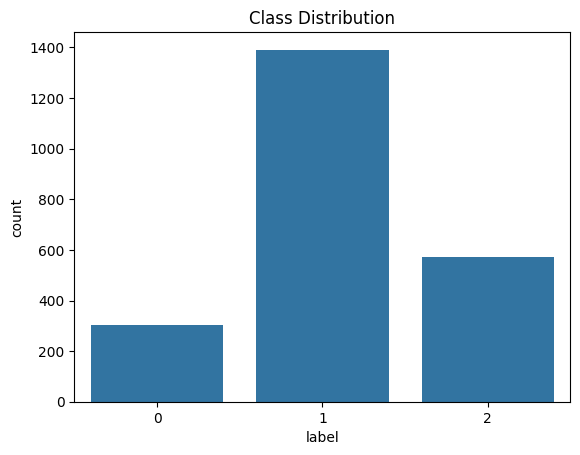

In [ ]:
sns.countplot(x=df["label"])
plt.title("Class Distribution")
plt.show()


<Axes: title={'center': 'Balanced Class Distribution'}, xlabel='label'>

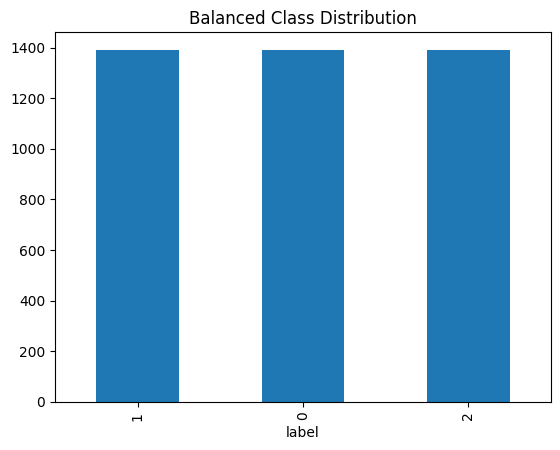

In [ ]:
# Separate classes
df_majority = df[df["label"] == 1]  # Majority class (neutral)
df_minority_0 = df[df["label"] == 0]  # Negative class
df_minority_2 = df[df["label"] == 2]  # Positive class

# Oversample minority classes to match majority
df_minority_0_upsampled = resample(df_majority, replace=True, n_samples=len(df_minority_0), random_state=42)
df_minority_2_upsampled = resample(df_minority_2, replace=True, n_samples=len(df_minority_0), random_state=42)

# Combine all classes
df_balanced = pd.concat([df_minority_0, df_minority_0_upsampled, df_minority_2_upsampled])

# Shuffle dataset
df_balanced = df_balanced.sample(frac=1, random_state=42)

# Check new class distribution
df_balanced["label"].value_counts().plot(kind="bar", title="Balanced Class Distribution")


In [ ]:
# Step 3: Train-Test Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["sentence"].tolist(), df["label"].tolist(), test_size=0.2, random_state=42
)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_dict({"sentence": train_texts, "label": train_labels})
val_dataset = Dataset.from_dict({"sentence": val_texts, "label": val_labels})

## **2. Model Selection and Fine-Tuning**
- Use a **transformer model** (e.g., **BERT, RoBERTa, DistilBERT**) from Hugging Face.
- Fine-tune the model on your selected dataset using libraries such as **Simple Transformers** or **Hugging Face Transformers**.
- Document your training process, including:
  - Hyperparameter choices  
  - Evaluation metrics  
  - Challenges encountered  



In [ ]:
MODEL_NAME = "ProsusAI/finbert"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True, max_length=128)

# Apply tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/1811 [00:00<?, ? examples/s]

Map:   0%|          | 0/453 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3, ignore_mismatched_sizes=True)

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

## **3. Evaluation**
- Evaluate your fine-tuned model using appropriate metrics:
  - **Binary Classification**: Accuracy, F1-score, ROC-AUC  
  - **Multi-Class / Multi-Label**: Precision, Recall, F1-score  
- Provide a **brief analysis** of the model’s performance on the test set.



In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)  # Convert logits to predicted class
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

In [ ]:
training_args = TrainingArguments(
    output_dir="./finbert-binary-results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none"
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Start training
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.225200,0.102011,0.969095,0.969021,0.969055,0.969095
2,0.068500,0.096220,0.969095,0.969178,0.969366,0.969095
3,0.048100,0.098803,0.971302,0.971380,0.971480,0.971302


TrainOutput(global_step=681, training_loss=0.19397856873800642, metrics={'train_runtime': 187.5498, 'train_samples_per_second': 28.968, 'train_steps_per_second': 3.631, 'total_flos': 357373799629056.0, 'train_loss': 0.19397856873800642, 'epoch': 3.0})

In [ ]:
# Evaluate on validation set
results = trainer.evaluate()
print("Evaluation Metrics:", results)

Evaluation Metrics: {'eval_loss': 0.0988025963306427, 'eval_accuracy': 0.9713024282560706, 'eval_f1': 0.9713803218626222, 'eval_precision': 0.9714800145054588, 'eval_recall': 0.9713024282560706, 'eval_runtime': 3.3535, 'eval_samples_per_second': 135.082, 'eval_steps_per_second': 16.997, 'epoch': 3.0}


In [ ]:
train_results = trainer.evaluate(train_dataset)
print("Training Metrics:", train_results)

Training Metrics: {'eval_loss': 0.028904153034090996, 'eval_accuracy': 0.992821645499724, 'eval_f1': 0.9928200044503439, 'eval_precision': 0.9928284268462739, 'eval_recall': 0.992821645499724, 'eval_runtime': 14.8991, 'eval_samples_per_second': 121.551, 'eval_steps_per_second': 15.236, 'epoch': 3.0}


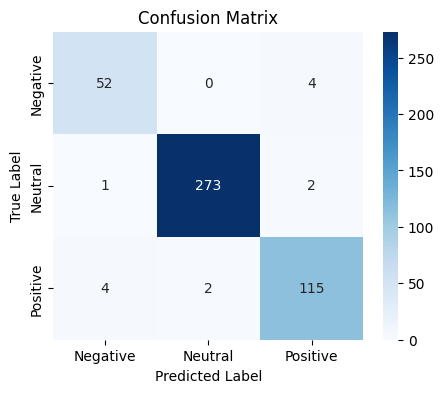

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get model predictions
predictions = trainer.predict(val_dataset).predictions
predictions = predictions.argmax(axis=1)

# Compute confusion matrix
cm = confusion_matrix(val_labels, predictions)

# Plot
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative","Neutral", "Positive"], yticklabels=["Negative","Neutral", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## **4. Deployment (Optional)**
- Optionally, develop a **simple web application** using **Streamlit** or **Gradio**.
- The app should allow users to **input text and see classification predictions**.
- This step demonstrates how your model can be used in a **real-world application**.



## **5. Upload to Hugging Face Hub**
- Once fine-tuning is complete, upload your model to the **Hugging Face Hub**.
- Provide a **repository link** and ensure your **model card** includes:
  - Dataset details  
  - Training parameters  
  - Evaluation metrics  
  - Intended use  